In [34]:
import tensorflow as tf
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import r2_score


from scipy import stats
import plotly.graph_objects as go
import plotly.express as px  # For easier rendering
import plotly.io as pio
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential  # Import Sequential
from tensorflow.keras import Model  # Import Model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.optimizers import Adam

In [35]:
start="2012-01-01"
end="2022-12-21"
stock="GOOG"
data=yf.download(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [36]:
data.columns = ['_'.join(col).strip() for col in data.columns.values]

print(data.head())  # Verify the new column names

            Adj Close_GOOG  Close_GOOG  High_GOOG   Low_GOOG  Open_GOOG  \
Date                                                                      
2012-01-03       16.532528   16.573130  16.641375  16.248346  16.262545   
2012-01-04       16.603836   16.644611  16.693678  16.453827  16.563665   
2012-01-05       16.373516   16.413727  16.537264  16.344486  16.491436   
2012-01-06       16.150156   16.189817  16.438385  16.184088  16.417213   
2012-01-09       15.465409   15.503389  16.114599  15.472754  16.102144   

            Volume_GOOG  
Date                     
2012-01-03    147611217  
2012-01-04    114989399  
2012-01-05    131808205  
2012-01-06    108119746  
2012-01-09    233776981  


In [37]:
data.duplicated().values.any()

False

In [38]:
data.reset_index(inplace=True)

In [39]:
data.drop(columns=['Adj Close_GOOG'], axis=1,inplace=True)
data

,Date,Close_GOOG,High_GOOG,Low_GOOG,Open_GOOG,Volume_GOOG
0,2012-01-03,16.573130,16.641375,16.248346,16.262545,147611217
1,2012-01-04,16.644611,16.693678,16.453827,16.563665,114989399
2,2012-01-05,16.413727,16.537264,16.344486,16.491436,131808205
3,2012-01-06,16.189817,16.438385,16.184088,16.417213,108119746
4,2012-01-09,15.503389,16.114599,15.472754,16.102144,233776981
...,...,...,...,...,...,...
2756,2022-12-14,95.309998,97.220001,93.940002,95.540001,26452900
2757,2022-12-15,91.199997,94.029999,90.430000,93.540001,28298800
2758,2022-12-16,90.860001,91.750000,90.010002,91.199997,48485500
2759,2022-12-19,89.150002,91.199997,88.925003,90.879997,23020500


In [40]:
scaler = MinMaxScaler()

# Select columns to scale
columns_to_scale = ['Close_GOOG', 'High_GOOG', 'Low_GOOG', 'Open_GOOG', 'Volume_GOOG']

# Apply the scaler
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

print(data)
# Select columns to scale
columns_to_scale = ['Close_GOOG', 'High_GOOG', 'Low_GOOG', 'Open_GOOG', 'Volume_GOOG']

# Apply the scaler
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

print(data)

           Date  Close_GOOG  High_GOOG  Low_GOOG  Open_GOOG  Volume_GOOG
0    2012-01-03    0.019367   0.018698  0.017550   0.016724     0.295258
1    2012-01-04    0.019889   0.019077  0.019061   0.018907     0.229936
2    2012-01-05    0.018201   0.017944  0.018257   0.018384     0.263614
3    2012-01-06    0.016564   0.017228  0.017078   0.017845     0.216181
4    2012-01-09    0.011546   0.014882  0.011848   0.015561     0.467796
...         ...         ...        ...       ...        ...          ...
2756 2022-12-14    0.594992   0.602433  0.588701   0.591584     0.052652
2757 2022-12-15    0.564945   0.579324  0.562898   0.577082     0.056348
2758 2022-12-16    0.562459   0.562807  0.559810   0.560114     0.096770
2759 2022-12-19    0.549958   0.558823  0.551834   0.557794     0.045779
2760 2022-12-20    0.553467   0.548536  0.545327   0.542203     0.043689

[2761 rows x 6 columns]
           Date  Close_GOOG  High_GOOG  Low_GOOG  Open_GOOG  Volume_GOOG
0    2012-01-03    0.01936

Output Range of Tanh:

The tanh activation function maps inputs to the range [-1, 1]. Using MinMaxScaler ensures that the input data is scaled into a range that matches the activation function's output domain, leading to more effective learning.
Efficient Gradient Flow:

When inputs are scaled to align with the tanh range, the gradients during backpropagation stay well within manageable values, reducing issues like vanishing or exploding gradients.
Avoiding Saturation:

If the input data is outside the range that tanh can handle effectively (e.g., very large positive or negative values), the function saturates (outputs values close to -1 or 1), leading to very small gradients. MinMaxScaler prevents this by scaling the inputs to match the effective range of tanh.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2761 entries, 0 to 2760
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2761 non-null   datetime64[ns]
 1   Close_GOOG   2761 non-null   float64       
 2   High_GOOG    2761 non-null   float64       
 3   Low_GOOG     2761 non-null   float64       
 4   Open_GOOG    2761 non-null   float64       
 5   Volume_GOOG  2761 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 129.5 KB


In [42]:
data.describe()

,Date,Close_GOOG,High_GOOG,Low_GOOG,Open_GOOG,Volume_GOOG
count,2761,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000
mean,2017-06-28 05:55:10.539659520,0.302637,0.302867,0.300643,0.299851,0.090874
min,2012-01-03 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014-10-01 00:00:00,0.098723,0.098517,0.097532,0.097664,0.049819
50%,2017-06-28 00:00:00,0.237716,0.236249,0.237384,0.235642,0.065658
75%,2020-03-26 00:00:00,0.405706,0.404794,0.396264,0.400271,0.106601
max,2022-12-20 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,0.261543,0.262212,0.260000,0.259421,0.072182


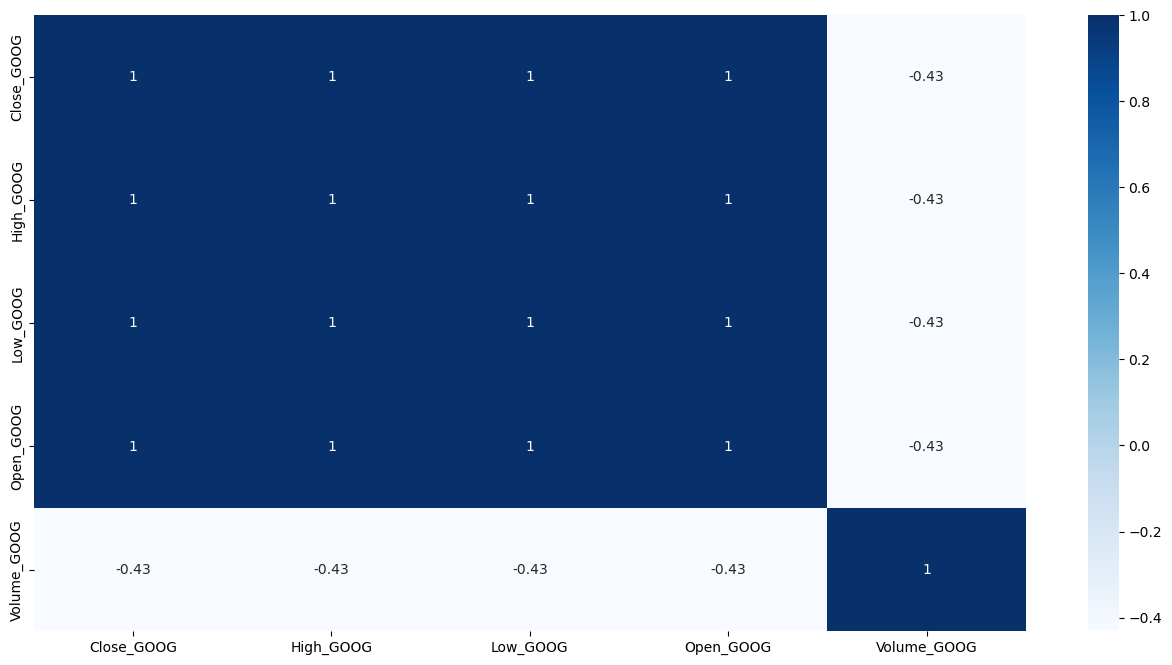

In [43]:
numeric_df = data.select_dtypes(include=['number'])
correlations = numeric_df.corr()
plt.figure(figsize=(16,8))
sns.heatmap(numeric_df.corr(), cmap="Blues", annot=True)
plt.show()

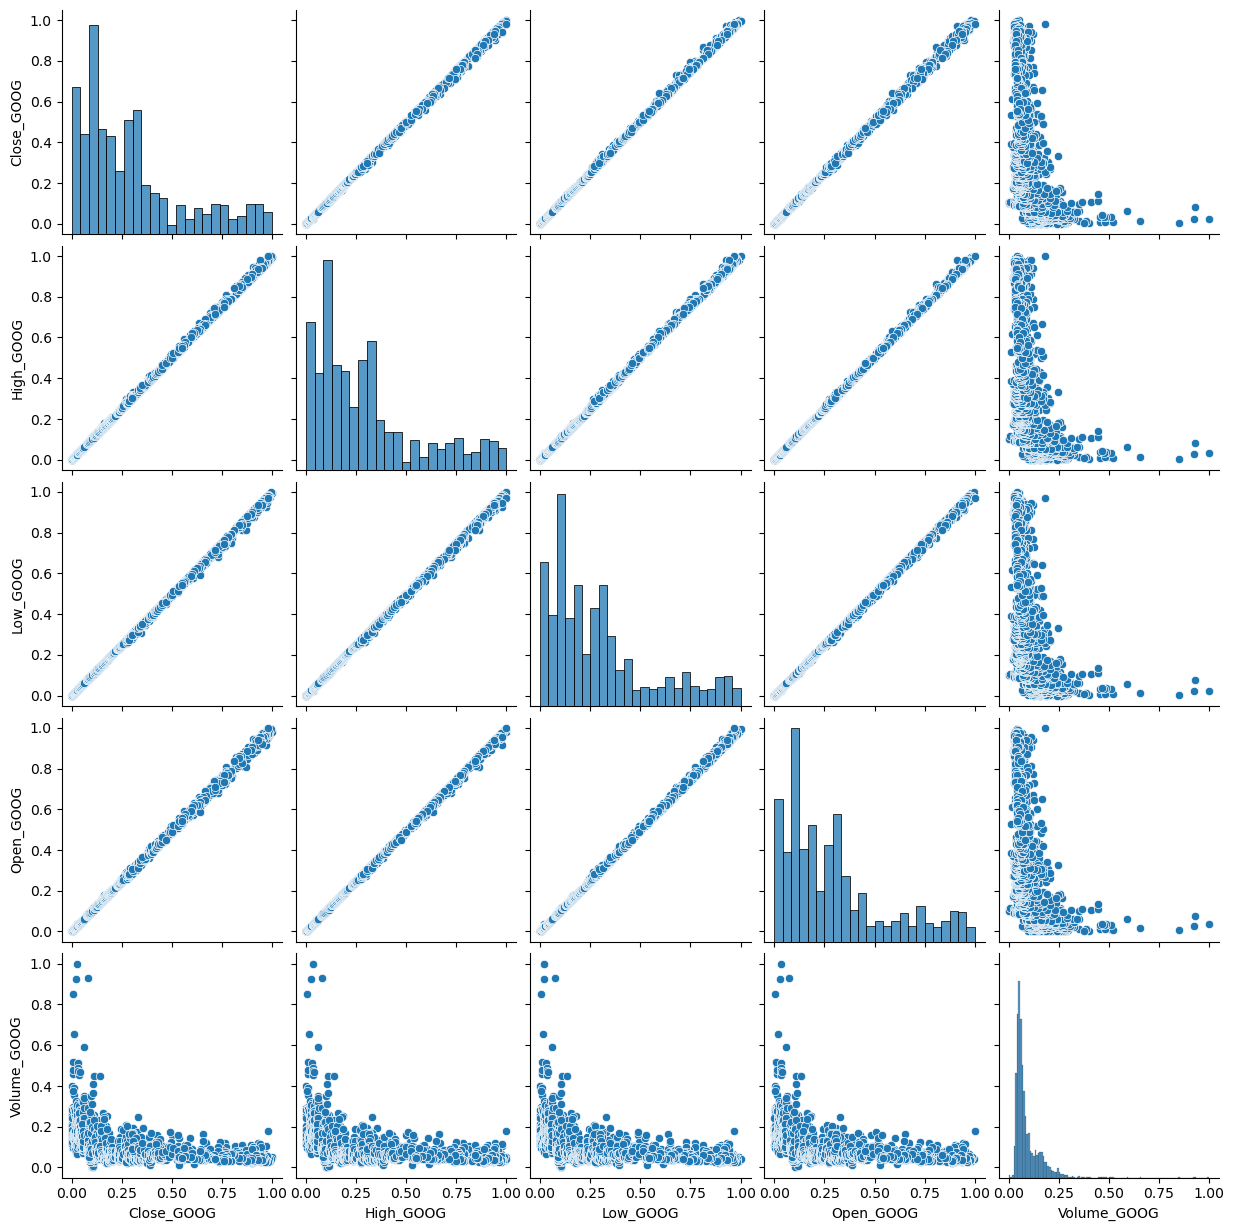

In [44]:
sns.pairplot(data)

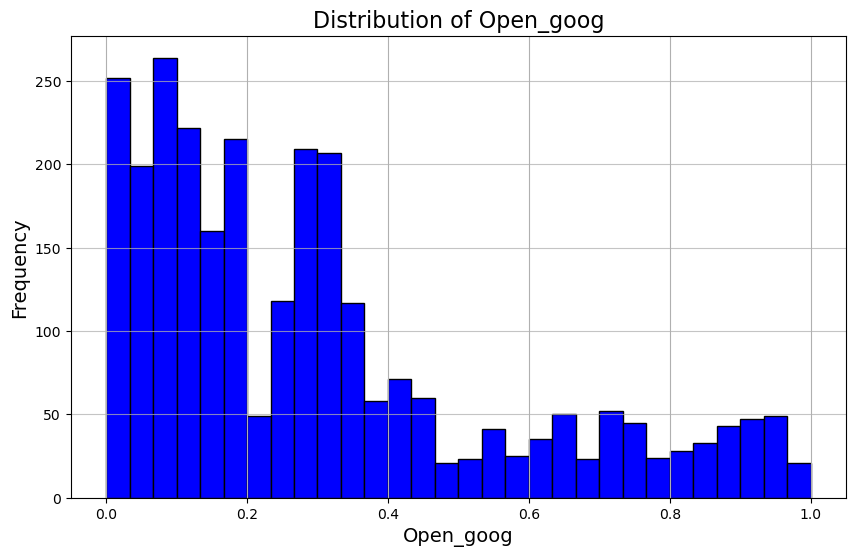

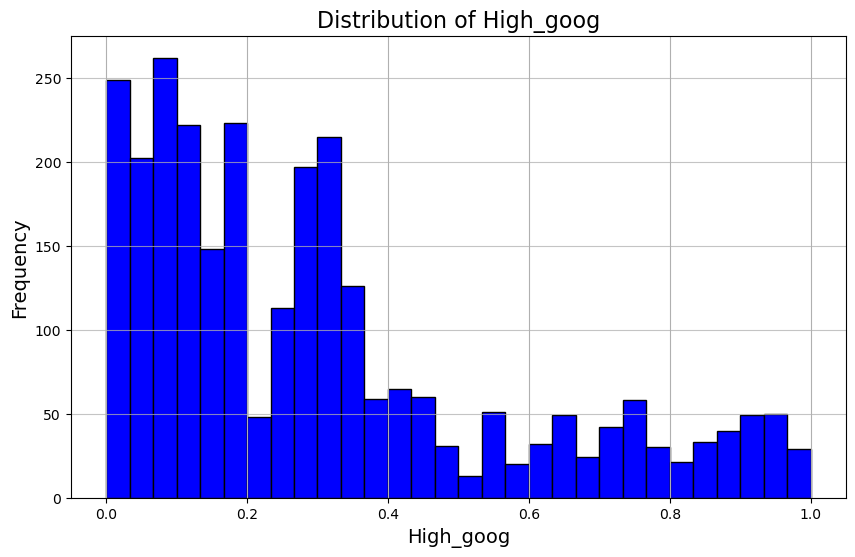

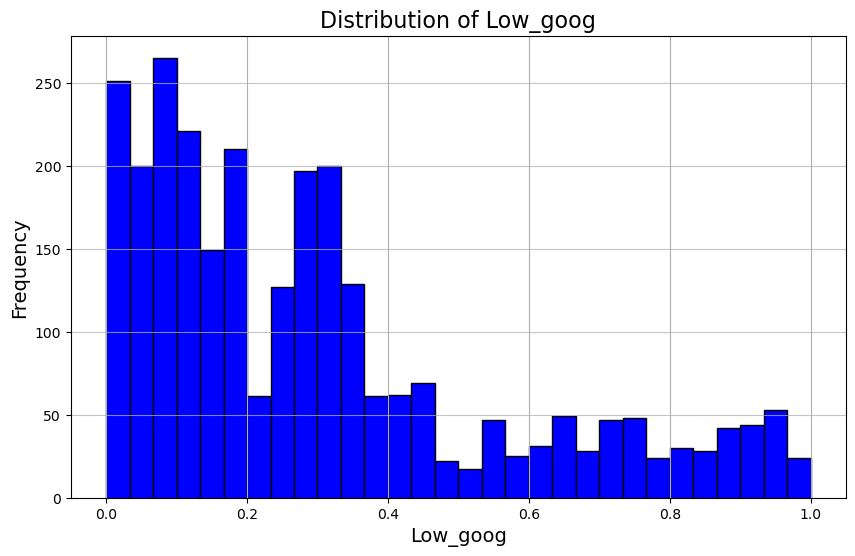

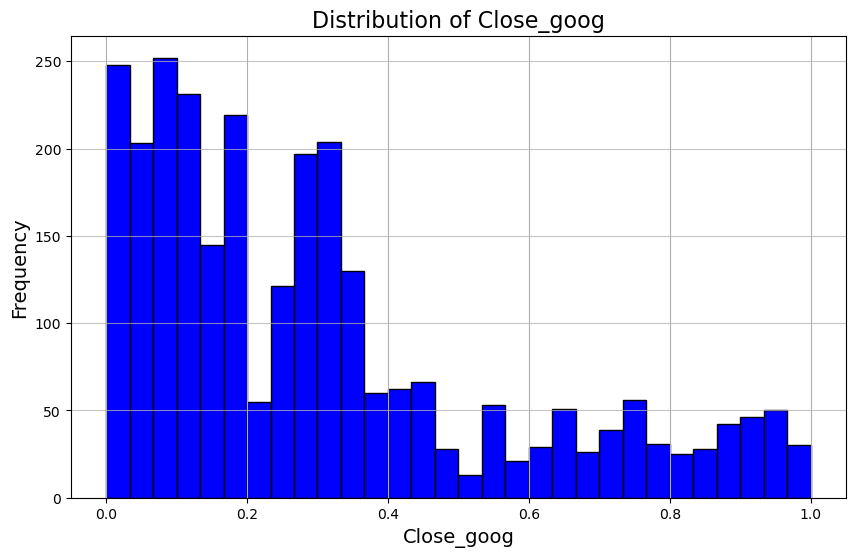

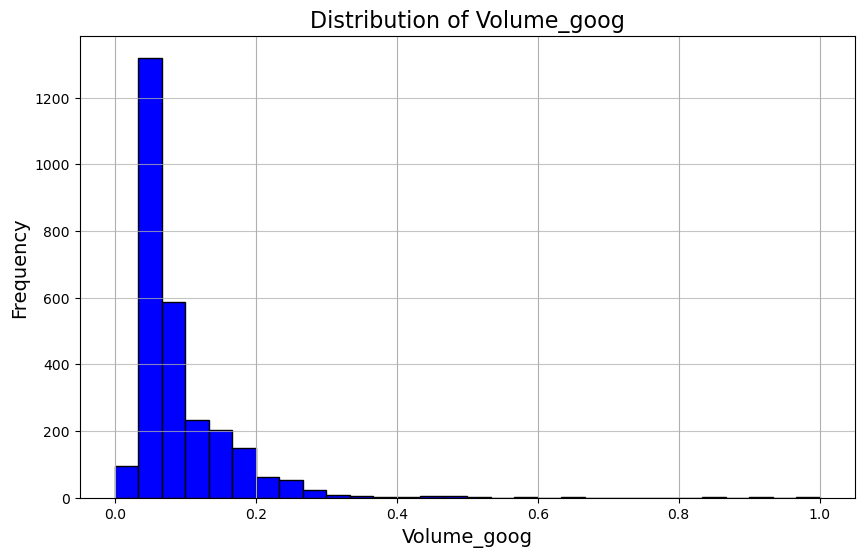

In [45]:
columns_to_plot = ['Open_GOOG', 'High_GOOG', 'Low_GOOG', 'Close_GOOG', 'Volume_GOOG']
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    data[column].hist(bins=30, color='blue', edgecolor='black')
    plt.title(f'Distribution of {column.capitalize()}', fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

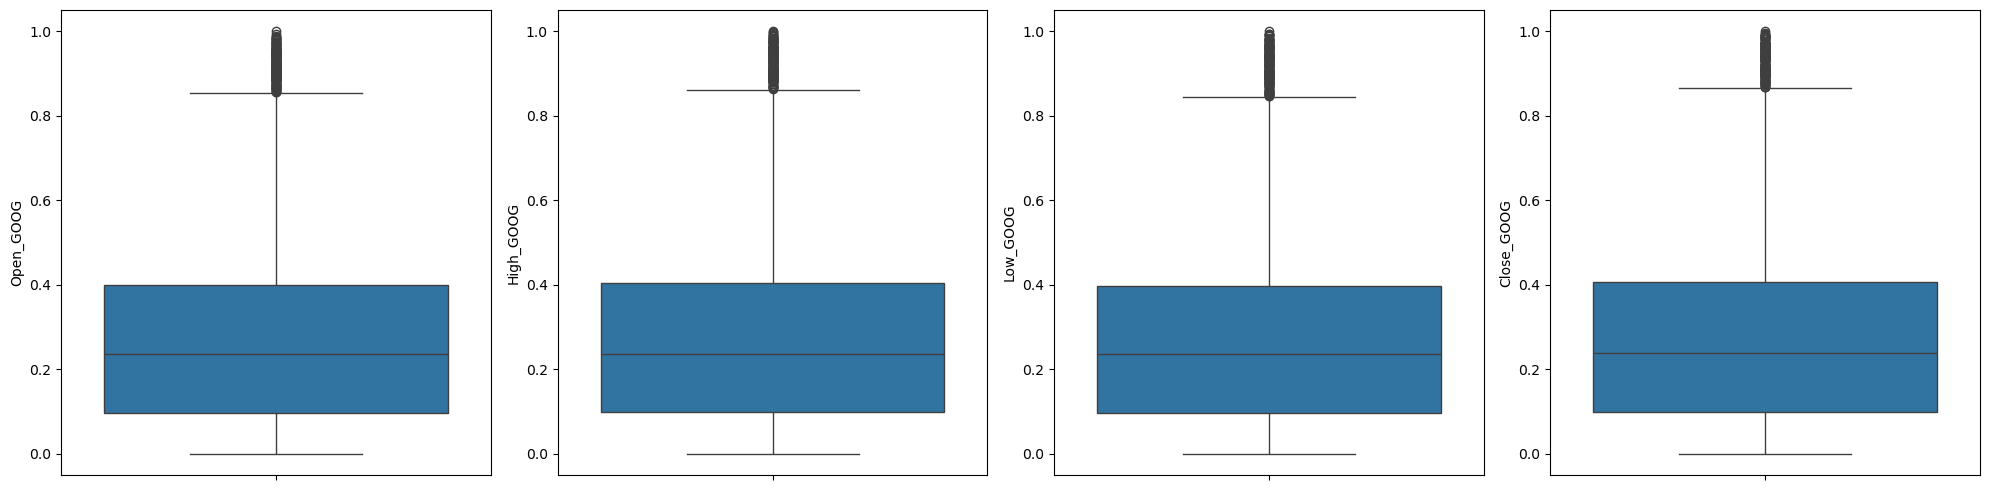

In [46]:
f, axes = plt.subplots(1, 4, figsize=(20,5))
sns.boxplot(y='Open_GOOG', data=data, ax=axes[0])
sns.boxplot(y='High_GOOG', data=data, ax=axes[1])
sns.boxplot(y='Low_GOOG', data=data, ax=axes[2])
sns.boxplot(y='Close_GOOG', data=data, ax=axes[3])
plt.tight_layout()
plt.show()

In [47]:
x=data[['Open_GOOG','High_GOOG','Low_GOOG','Volume_GOOG']].values
y=data['Close_GOOG'].values 

In [48]:

x_train, x_remaining, y_train, y_remaining = train_test_split(x, y, test_size=0.2, random_state=1)

x_val, x_test, y_val, y_test = train_test_split(x_remaining, y_remaining, test_size=0.5, random_state=1)

# Print the shapes to verify
print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (2208, 4)
x_val shape: (276, 4)
x_test shape: (277, 4)
y_train shape: (2208,)
y_val shape: (276,)
y_test shape: (277,)


In [49]:
y_test

array([0.16441826, 0.18161312, 0.1091916 , 0.33885998, 0.28464714,
       0.10419336, 0.28272806, 0.28935892, 0.63904289, 0.33240092,
       0.71282291, 0.32533143, 0.90635661, 0.08411834, 0.17159741,
       0.10385435, 0.06335142, 0.41784892, 0.94095838, 0.15152576,
       0.17850241, 0.00830131, 0.09324269, 0.94660967, 0.16994516,
       0.31988128, 0.30440808, 0.29103308, 0.25655558, 0.00172071,
       0.56494478, 0.37521632, 0.28748371, 0.18595937, 0.88435866,
       0.31628804, 0.15764119, 0.28621895, 0.32224264, 0.46176822,
       0.72630762, 0.06285068, 0.33846154, 0.32509382, 0.1898487 ,
       0.53504017, 0.67779349, 0.69779932, 0.2961908 , 0.0986124 ,
       0.01945591, 0.01521148, 0.93963514, 0.88333873, 0.02404995,
       0.34014301, 0.18952701, 0.74453328, 0.19148264, 0.27748992,
       0.66309888, 0.10432081, 0.04779579, 0.16255402, 0.82268518,
       0.95741124, 0.28590091, 0.31710684, 0.95763056, 0.43934253,
       0.11349998, 0.32057578, 0.67260287, 0.47271242, 0.20229

In [50]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [51]:
x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

x_train_reshaped.shape

(2208, 4, 1)

In [52]:
model = Sequential()

model.add(LSTM(units=50, activation='tanh', return_sequences=True, input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2])))
model.add(Dropout(0.6))

model.add(LSTM(units=60, activation='tanh', return_sequences=True))
model.add(Dropout(0.7))

model.add(LSTM(units=80, activation='tanh', return_sequences=True))
model.add(Dropout(0.8))

model.add(LSTM(units=120, activation='tanh',return_sequences=False))
model.add(Dropout(0.9))

model.add(Dense(units=1))

Vanishing Gradients: The gradients become very small, slowing down or halting the learning process, especially in deep networks or when using sigmoid/tanh activations.

Exploding Gradients: The gradients become excessively large, leading to instability and failure to converge.


Capturing Complex Patterns
The symmetric output range of tanh is beneficial for modeling sequential data, which may have both positive and negative variations (e.g., stock prices, time-series data).



Smooth Transitions
The smooth curve of tanh provides a gradient across its input range, allowing LSTMs to learn fine-grained changes in long-term dependencies.




Prevents Exploding or Vanishing Cell State Values
By bounding the hidden states, tanh prevents the exploding gradient problem and reduces the impact of the vanishing gradient problem in conjunction with LSTM gates.

In [53]:
optimizer = Adam(learning_rate=0.0001)


In [54]:
model.compile(optimizer=optimizer,loss='mean_squared_error')

In [55]:
y_train

array([0.10247639, 0.33302235, 0.89026206, ..., 0.15894616, 0.02301023,
       0.16799321])

In [56]:
y_train_reshaped = y_train.reshape(-1, 1)
y_train_reshaped

array([[0.10247639],
       [0.33302235],
       [0.89026206],
       ...,
       [0.15894616],
       [0.02301023],
       [0.16799321]])

In [57]:
history=model.fit(x_train_reshaped,y_train_reshaped,epochs=10,batch_size=32,validation_data=(x_val,y_val),verbose=1)

Epoch 1/10
69/69 [==============================] - 9s 42ms/step - loss: 0.1354 - val_loss: 0.1091
Epoch 2/10
69/69 [==============================] - 1s 11ms/step - loss: 0.0848 - val_loss: 0.0615
Epoch 3/10
69/69 [==============================] - 1s 10ms/step - loss: 0.0676 - val_loss: 0.0522
Epoch 4/10
69/69 [==============================] - 1s 10ms/step - loss: 0.0542 - val_loss: 0.0349
Epoch 5/10
69/69 [==============================] - 1s 10ms/step - loss: 0.0353 - val_loss: 0.0110
Epoch 6/10
69/69 [==============================] - 1s 10ms/step - loss: 0.0228 - val_loss: 0.0060
Epoch 7/10
69/69 [==============================] - 1s 10ms/step - loss: 0.0208 - val_loss: 0.0052
Epoch 8/10
69/69 [==============================] - 1s 11ms/step - loss: 0.0204 - val_loss: 0.0037
Epoch 9/10
69/69 [==============================] - 1s 10ms/step - loss: 0.0173 - val_loss: 0.0031
Epoch 10/10
69/69 [==============================] - 1s 10ms/step - loss: 0.0179 - val_loss: 0.0025


In [58]:
x_test

array([[0.16128089, 0.1620418 , 0.16296797, 0.06310647],
       [0.18108766, 0.18079728, 0.18244948, 0.05055549],
       [0.10938476, 0.10921849, 0.10811776, 0.19345282],
       ...,
       [0.12771485, 0.12739234, 0.12801889, 0.06800833],
       [0.97996126, 0.98044032, 0.98140069, 0.04300247],
       [0.01979964, 0.01903185, 0.02006426, 0.07384792]])

In [59]:
x_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_test_reshaped

array([[[0.16128089],
        [0.1620418 ],
        [0.16296797],
        [0.06310647]],

       [[0.18108766],
        [0.18079728],
        [0.18244948],
        [0.05055549]],

       [[0.10938476],
        [0.10921849],
        [0.10811776],
        [0.19345282]],

       ...,

       [[0.12771485],
        [0.12739234],
        [0.12801889],
        [0.06800833]],

       [[0.97996126],
        [0.98044032],
        [0.98140069],
        [0.04300247]],

       [[0.01979964],
        [0.01903185],
        [0.02006426],
        [0.07384792]]])

In [60]:
x_val_reshaped = x_val.reshape((x_val.shape[0],x_val.shape[1],1))


In [61]:
y_predict=model.predict(x_test_reshaped)

9/9 [==============================] - 2s 4ms/step


In [62]:
y_test

array([0.16441826, 0.18161312, 0.1091916 , 0.33885998, 0.28464714,
       0.10419336, 0.28272806, 0.28935892, 0.63904289, 0.33240092,
       0.71282291, 0.32533143, 0.90635661, 0.08411834, 0.17159741,
       0.10385435, 0.06335142, 0.41784892, 0.94095838, 0.15152576,
       0.17850241, 0.00830131, 0.09324269, 0.94660967, 0.16994516,
       0.31988128, 0.30440808, 0.29103308, 0.25655558, 0.00172071,
       0.56494478, 0.37521632, 0.28748371, 0.18595937, 0.88435866,
       0.31628804, 0.15764119, 0.28621895, 0.32224264, 0.46176822,
       0.72630762, 0.06285068, 0.33846154, 0.32509382, 0.1898487 ,
       0.53504017, 0.67779349, 0.69779932, 0.2961908 , 0.0986124 ,
       0.01945591, 0.01521148, 0.93963514, 0.88333873, 0.02404995,
       0.34014301, 0.18952701, 0.74453328, 0.19148264, 0.27748992,
       0.66309888, 0.10432081, 0.04779579, 0.16255402, 0.82268518,
       0.95741124, 0.28590091, 0.31710684, 0.95763056, 0.43934253,
       0.11349998, 0.32057578, 0.67260287, 0.47271242, 0.20229

In [63]:
y_predict

array([[0.16078337],
       [0.17452896],
       [0.12628157],
       [0.2978941 ],
       [0.25139454],
       [0.12084535],
       [0.24889952],
       [0.2560671 ],
       [0.5628754 ],
       [0.28512838],
       [0.62823784],
       [0.28156552],
       [0.81116205],
       [0.10894014],
       [0.16992985],
       [0.11982886],
       [0.09391889],
       [0.35890648],
       [0.83866477],
       [0.15309279],
       [0.17008644],
       [0.058398  ],
       [0.11334062],
       [0.8593803 ],
       [0.16900831],
       [0.27592936],
       [0.26297668],
       [0.25630578],
       [0.22913972],
       [0.05600329],
       [0.49577722],
       [0.3210936 ],
       [0.25381106],
       [0.17578155],
       [0.7820474 ],
       [0.2713264 ],
       [0.15587835],
       [0.2511614 ],
       [0.27477753],
       [0.38490298],
       [0.6357736 ],
       [0.09290299],
       [0.2926802 ],
       [0.28415963],
       [0.18004878],
       [0.46373245],
       [0.5966426 ],
       [0.611

In [64]:
from sklearn.metrics import r2_score


train_predictions = model.predict(x_train_reshaped)
val_predictions = model.predict(x_val_reshaped)
test_predictions = model.predict(x_test_reshaped)

r2_train = r2_score(y_train_reshaped, train_predictions)
r2_val = r2_score(y_val, val_predictions)
r2_test = r2_score(y_test, test_predictions)

# Print the R² scores
print(f"R² score for Training Data: {r2_train}")
print(f"R² score for Validation Data: {r2_val}")
print(f"R² score for Test Data: {r2_test}")


9/9 [==============================] - 0s 4ms/step
R² score for Training Data: 0.9611619141045116
R² score for Validation Data: 0.9620999126068501
R² score for Test Data: 0.9635995167247058


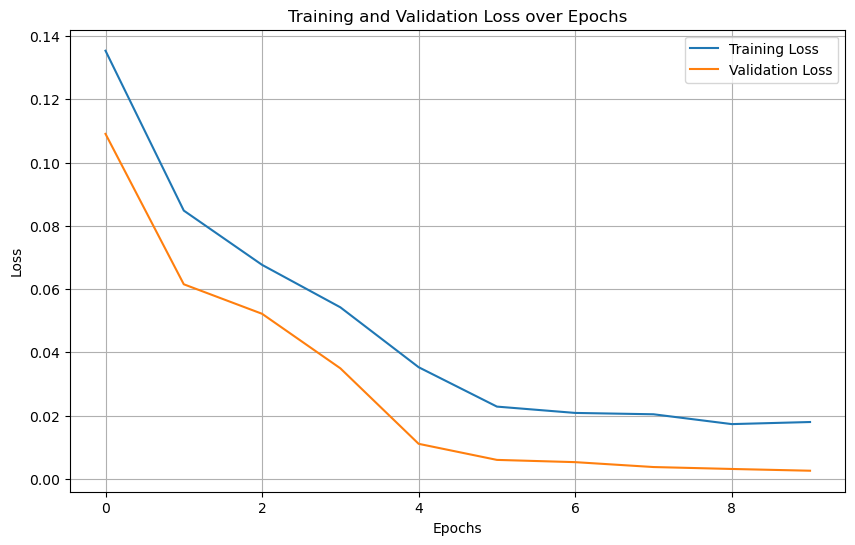

In [65]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


9/9 [==============================] - 0s 6ms/step


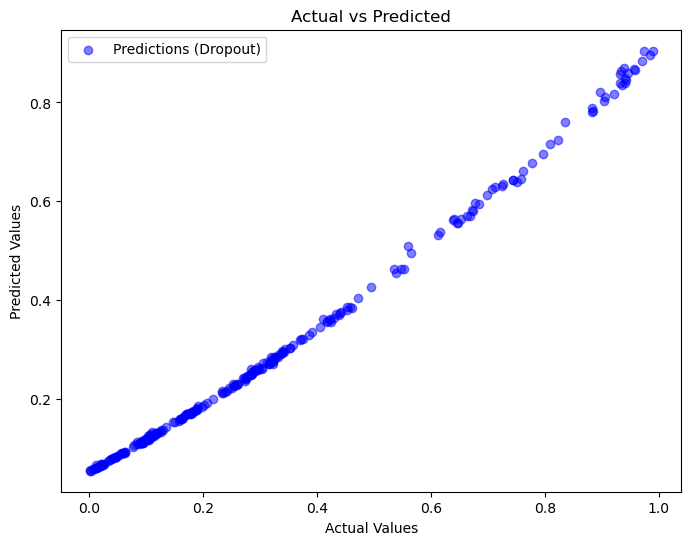

In [66]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, model.predict(x_test_reshaped), label='Predictions (Dropout)', alpha=0.5, color='blue')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.legend()
